# Descrizione del problema - Exploration

L’obiettivo è sviluppare un agente autonomo capace di esplorare un ambiente sconosciuto massimizzando la copertura dell’area, evitando collisioni con ostacoli statici o dinamici.
Il sistema deve bilanciare due task contemporaneamente:
- ***esplorare*** nuove regioni dell’ambiente;
- ***evitare ostacoli*** per garantire sicurezza e continuità della missione.

## Ambiente

L'ambiente è una griglia 2D di dimensioni variabili (5x5, 20x20, 30x30 metri) in cui sono presenti ostacoli rettangolari di dimensioni variabili disposti in posizioni casuali e con orientamenti casuali.
Oltre agli ostacoli, nell'ambiente sono presenti anche uno o più agenti circolari di raggio fisso (0.25 metri) che si muovono all'interno dell'ambiente.

### Osservazioni

Ogni agente riceve un insieme di informazioni che descrivono sia ciò che percepisce localmente sia il proprio stato all’interno dell’ambiente. In particolare, l’osservazione comprende:
- **8 sensori di prossimità**, disposti intorno all’agente in modo uniforme ogni 45 gradi, utilizzati per stimare la distanza dagli ostacoli, normalizzata tra 0 e 1. Un valore pari a 1 indica assenza di ostacoli entro la portata massima del sensore (1 metro), mentre 0 corrisponde a una collisione immediata;
- la **posizione** dell'agente, espressa in coordinate discretizzate all’interno della mappa. Tale informazione funge da riferimento spaziale, analogo al contributo che un sensore GPS reale fornirebbe;
- l’**orientazione**, discretizzata in un numero finito di direzioni (**8 direzioni distanziate di 45°**) utile per interpretare il movimento futuro e fornire una forma di consapevolezza spaziale.

La posizione è stata inclusa nello stato seguendo un approccio simile a quello del *Taxi Problem*, in cui fornire informazioni spaziali chiare permette di distinguere correttamente stati diversi e aggiornare la Q-table in modo coerente.

Il simulatore mette a disposizione anche gli **8 sensori di luce**, ma tali informazioni non vengono impiegate nella codifica dello stato, poiché non rilevanti per il completamento del task.

### Azioni

L’agente si muove all’interno dell’ambiente mediante un sistema a velocità differenziale, controllando indipendentemente la velocità delle due ruote (sinistra e destra). In entrambe le implementazioni sviluppate, lo spazio delle azioni è discreto e ciascuna azione corrisponde a una combinazione predefinita di velocità per le due ruote.

Le possibili azioni sono:

- *avanti*: entrambe le ruote alla massima velocità (1.0);
- *rotazione sul posto a sinistra*: ruota sinistra a velocità negativa (-1.0), ruota destra alla massima velocità (1.0);
- *rotazione sul posto a destra*: ruota sinistra alla massima velocità (1.0), ruota destra a velocità negativa (-1.0).

Successivamente sono state introdotte anche le seguenti due varianti di rotazioni leggere:
- *rotazione leggera a sinistra*:
    - ruota sinistra a velocità ridotta (0.5), ruota destra alla massima velocità (1.0);
    - ruota sinistra ferma (0.0), ruota destra alla massima velocità (1.0);
- *rotazione leggera a destra*:
    - ruota sinistra alla massima velocità (1.0), ruota destra a velocità ridotta (0.5);
    - ruota sinistra alla massima velocità (1.0), ruota destra ferma (0.0).

## Definizione di successo

Il criterio di successo dell’agente è definito sulla base della quantità di area esplorata all’interno della griglia. L’ambiente mantiene una matrice `visited` di dimensioni `grid_size`, che registra le celle visitate almeno una volta dall’agente durante l’episodio.

Ad ogni passo, la posizione dell’agente viene convertita in coordinate di griglia e la relativa cella viene marcata come visitata. Il grado di esplorazione viene quindi calcolato come:

$$
\text{explored\_ratio} = \frac{\text{celle visitate}}{\text{celle totali}}
$$

Questo valore viene incluso nel dizionario `info` sia durante la fase di `reset()` sia ad ogni chiamata a `step()`.

Un episodio viene considerato riuscito quando l’agente ha esplorato almeno una certa percentuale della mappa totale. Questa soglia definisce l’obiettivo minimo di copertura necessario per considerare l’episodio completato con successo. Il criterio è valutato indipendentemente dal reward istantaneo e dalla condizione di terminazione, poiché:
- la terminazione può avvenire anche a causa di eventi negativi, come una collisione;
- il reward non è sufficientemente stabile o rappresentativo dell’obiettivo globale, in quanto può fluttuare a causa delle dinamiche locali dell’ambiente e non riflette in modo affidabile il progresso effettivo nell’esplorazione.


## Valutazione
<!-- TODO: numero episodi di test -->
La valutazione delle performance dell'agente viene effettuata calcolando la percentuale di episodi completati con successo su un totale di 64 episodi di test.
Ogni episodio utilizza una configurazione ambientale diversa, con l'agente posizionato in una posizione iniziale casuale.
Le 64 configurazioni sono suddivise in:
- 50 ambienti piccoli (5×5 metri);
- 14 ambienti medi (10×10 metri).

Per ogni episodio vengono calcolate le seguenti metriche:
- *Success rate*: percentuale di episodi completati con successo;
- *Average steps*: numero medio di passi effettuati prima della collisione o del completamento dell’episodio;
- *TD loss*: calcolata solo per l'algoritmo DQ-Learning, rappresenta la temporal difference loss media e misura la stabilità delle predizioni del modello durante l’episodio.

## Analisi errori

Le metriche adottate consentono di individuare le principali difficoltà incontrate dall’agente durante l’esplorazione.

Il *Success rate* evidenzia eventuali problemi di adattabilità: differenze significative tra ambienti di diversa dimensione indicano che l’agente non generalizza in modo efficace.

Nel caso del DQN, valori elevati e persistenti di *TD loss* suggeriscono instabilità dell’apprendimento o difficoltà nel trarre beneficio dalle esperienze memorizzate.

L’andamento della *Moving Average Reward* permette di individuare pattern ricorrenti, come miglioramenti lenti, stagnazioni, o comportamenti problematici quali loop e ripetuti fallimenti in specifiche aree dell’ambiente.

Infine, *sessioni di debug visivo* vengono utilizzate per verificare che le tendenze osservate dalle metriche corrispondano a problemi reali nel comportamento dell’agente, facilitando l’identificazione di strategie inefficaci o instabilità durante l’esplorazione.

## Import delle librerie

Import delle librerie necessarie per gestire il percorso dei file, abilitare l’esecuzione asincrona, utilizzare barre di avanzamento, leggere e rielaborare configurazioni YAML, valutare gli agenti e generare i grafici dei risultati.

In [9]:
import sys
sys.path.append("../..")

import nest_asyncio
nest_asyncio.apply()

from tqdm import trange

from utils.reader import get_yaml_path, read_file
from utils.dict import rename_inner_keys, combine_inner_dict

from evaluation.agent_evaluation import evaluate

from utils.plotting import plot_all_q_agent, plot_all

# Q-Learning

Il task di exploration è stato affrontato inizialmente utilizzando un agente basato su Q-Learning.


## Import delle librerie

In [10]:
from environment.qlearning.exploration_env import ExplorationEnv
from agent.qagent import QAgent

## Connessione all'ambiente

In [11]:
server_address = "localhost:50051"
client_name = "RLClient"
q_env5 = ExplorationEnv(server_address, client_name, grid_size=(5, 5), orientation_bins=8)
q_env5.connect_to_client()

2025-12-11 10:40:41,446 — INFO — Discrete(5)
2025-12-11 10:40:41,447 — INFO — Discrete(200)
2025-12-11 10:40:41,448 — INFO — 25
2025-12-11 10:40:41,723 — INFO — ✓ Connected to localhost:50051



## Problemi riscontrati

Durante la fase di sperimentazione con il Q-learning sono emerse diverse criticità legate principalmente alla rappresentazione dello stato, alla dimensionalità dello spazio degli stati e alla natura delle informazioni percepite dall’agente.

### Caratteristiche informative insufficienti dello stato

Uno dei primi problemi individuati riguarda il fatto che le informazioni fornite dai sensori non sono sufficienti a garantire all’agente una conoscenza adeguata dell’ambiente. I soli sensori di prossimità, infatti, permettono esclusivamente di rilevare la presenza di ostacoli nelle vicinanze ma non forniscono alcun riferimento globale. Per questo motivo sono state aggiunte alla rappresentazione dello stato anche la posizione e l’orientazione dell'agente, così da fornire un minimo di consapevolezza spaziale.


### Impatto della discretizzazione della mappa sulla complessità

La dimensione dello spazio delle osservazioni dipende direttamente dalla discretizzazione della mappa. Sono stati testati due scenari:

- Mappa 5×5, con 8 orientazioni:
    - spazio osservazioni: 200 ($ = 5 \times 5 \times 8 $)
    - numero di azioni: 5
    - spazio stati (osservazioni × azioni): 1000
- Mappa 10×10, con 8 orientazioni:
    - spazio osservazioni: 800 ($ = 10 \times 10 \times 8 $)
    - numero di azioni: 5
    - spazio stati (osservazioni × azioni): 4000

### Problemi di coerenza tra discretizzazione e funzione di reward

Prima di adottare una formulazione semplificata dell’ambiente, sono state esplorate diverse soluzioni nel tentativo di mantenere la dimensionalità dello spazio delle osservazioni entro limiti contenuti, evitando un incremento significativo degli stati quando si passava dal caso 5×5 al caso 10×10.

In una prima configurazione, per l’ambiente 10×10 è stata utilizzata una discretizzazione più grossolana della posizione (passi da 2 m invece che da 1 m), in modo da ottenere la stessa dimensionalità dello spazio delle osservazioni del caso 5×5 (200 stati osservabili). In questo modo, l’ambiente risultava più grande, ma la complessità dello stato non aumentava.

Tuttavia, mantenendo invariata la funzione di reward, l’agente non riusciva ad apprendere in modo affidabile. Il problema principale derivava dall’incoerenza tra:
- la reward, calcolata sulla base del passaggio tra celle adiacenti di 1×1 m;
- l’osservazione, che rappresentava la posizione con una risoluzione di 2 m.

Con questa discrepanza, l’agente non era in grado di associare correttamente il segnale di reward ai propri spostamenti: poteva ricevere una reward positiva pur senza percepire, nell’osservazione, il passaggio da una cella all’altra. Ciò rendeva l’apprendimento instabile e impediva la formazione di una politica coerente.

Per ripristinare coerenza si è valutata l’ipotesi di modificare la reward in modo da considerare le celle della mappa 10×10 come celle da 2×2 m. Tuttavia, questa soluzione avrebbe reso l’ambiente equivalente a un ambiente 5×5, cambiando solo la scala ma non introducendo alcuna complessità aggiuntiva.

Per queste ragioni, l’approccio “a bassa dimensionalità” non era sostenibile senza compromettere la coerenza dell’ambiente. Ciò ha reso necessaria l’adozione di una formulazione più semplice ma internamente consistente, mantenendo la discretizzazione fine (1 m) e accettando una dimensionalità maggiore dello spazio degli stati.

### Esplosione della dimensionalità con i sensori di prossimità

Un’ulteriore criticità riguarda l’integrazione delle letture dei sensori di prossimità nello spazio degli stati. La discretizzazione di tali sensori può facilmente portare a un’esplosione combinatoria della dimensionalità. Anche considerando una discretizzazione estremamente semplice, con **solo due valori possibili per sensore**, almeno **tre sensori utili** e una **mappa 5×5**, si otterrebbero:
- possibili osservazioni: $2^3 \times 200 = 1600$
- spazio degli stati complessivo: 8000.

Inoltre, le informazioni fornite dai sensori di prossimità non sono direttamente correlate con quelle di posizione e orientazione: ciò compromette ulteriormente la capacità dell’agente di apprendere una relazione coerente tra stati, transizioni e reward.

Per queste ragioni, per il task basato su Q-learning tabellare, l’ambiente è stato semplificato per renderne l’apprendimento gestibile: sono state utilizzate mappe di dimensione 5×5 e 10×10, sono stati rimossi gli ostacoli e non sono stati considerati i sensori di prossimità. Queste semplificazioni sono state applicate solo in questo contesto, mentre altri approcci più avanzati possono gestire ambienti più complessi senza modifiche.

## Azioni

Le azioni disponibili per l’agente sono cinque, corrispondenti a movimenti avanti, rotazioni in senso orario e antiorario, e curve dolci a destra o sinistra.

```python
self.actions = [
    (1.0, 1.0),  # forward
    (1.0, -1.0),  # left
    (-1.0, 1.0),  # right
    (1.0, 0.5),  # soft right
    (0.5, 1.0),  # soft left
]
```

Durante lo sviluppo dell’agente sono stati effettuati diversi tentativi per definire l’insieme di azioni più efficace. Inizialmente si erano considerate solo le tre azioni principali (avanti, rotazione oraria e antioraria), ma questo limitava la capacità dell’agente di effettuare curve dolci, rendendo l’esplorazione meno fluida. Successivamente sono state aggiunte le due azioni “curve dolci” per permettere all’agente di modificare la traiettoria senza dover ruotare sul posto.

## Osservazioni

Per l’ambiente di esplorazione si è deciso di utilizzare la posizione dell’agente nella griglia e l’orientamento come osservazioni, senza considerare i sensori di prossimità o altre letture. La scelta è stata motivata dalla necessità di mantenere uno ***spazio degli stati gestibile*** per il Q-learning tabellare.

Ogni stato viene codificato combinando:

- la posizione dell’agente lungo l’asse X della griglia, con valori da `0` a `grid_size[0]-1`;
- la posizione lungo l’asse Y della griglia, con valori da `0` a `grid_size[1]-1`;
- l’orientamento, discretizzato in `orientation_bins` step angolari uguali (ad esempio 8 orientamenti in passi di 45°).

La codifica è effettuata dalla funzione `_encode_observation`, che restituisce un ***ID unico per ciascuna combinazione di posizione e orientamento***:

```python
def _encode_observation(self, proximity_values, light_values, position, orientation) -> int:
    orientation_step = 360.0 / self.orientation_bins
    orientation_idx = int((orientation % 360) / orientation_step)

    x = int(np.clip(position.x, 0, self.grid_size[0] - 1))
    y = int(np.clip(position.y, 0, self.grid_size[1] - 1))

    state = x
    state += y * self.grid_size[0]
    state += orientation_idx * self.grid_size[0] * self.grid_size[1]
    return state
```
Con questa codifica, lo spazio delle osservazioni ha dimensioni pari a:
$$
\text{num\_stati} = \text{grid\_size[0]} \times \text{grid\_size[1]} \times \text{orientation\_bins}
$$

Questa rappresentazione è risultata sufficiente a catturare le informazioni necessarie per il task di esplorazione, senza introdurre letture di sensori di prossimità, riducendo la dimensionalità complessiva rispetto a una rappresentazione più dettagliata che avrebbe considerato tutti i sensori.

## Configurazione ambienti

Per gli addestramenti sono stati utilizzati **200** e **500** ambienti di dimensioni 5×5 e 10×10 rispettivamente, generati in *anticipo*. Durante la generazione è stata verificata la validità della posizione iniziale dell’agente all’interno della mappa, per garantire che fosse sempre collocato in una cella corretta.
In ciascun ambiente, la posizione iniziale dell’agente variava in maniera randomica ad ogni episodio, assicurando esperienze diverse e una buona varietà di situazioni da esplorare.

A differenza di scenari più complessi, non sono stati inseriti ostacoli, in modo da semplificare il task e mantenere uno spazio degli stati gestibile per il Q-learning tabellare.
Questa scelta ha permesso di concentrare l’apprendimento dell’agente sul **task principale di esplorazione della griglia**, evitando che la presenza di ostacoli introducesse variabilità eccessiva o rendesse instabile il processo di addestramento.


## Approccio risolutivo

Di seguito sono descritte le componenti principali dell'approccio risolutivo basato su Q-Learning.

### Reward

La funzione di reward utilizzata per il task di esplorazione combina penalità e bonus con l’obiettivo di:
- incentivare l’esplorazione dell’ambiente;
- evitare comportamenti stagnanti (stallo/loop);
- prevenire collisioni;
- favorire il completamento della copertura della mappa.

La ricompensa totale è composta dalla somma di cinque contributi principali:

1. penalità/stallo dell’agente

    L’agente viene considerato *stuck* quando rimane nella stessa zona per diversi passi consecutivi.

    - Stuck penalty: −1.0
    - Not stuck bonus: +0.5

    Scopo: evitare immobilità e loop ripetitivi.

2. penalità per collisione

    Derivata dalla distanza dell'agente dagli ostacoli tramite sensori di prossimità.
    - Collision penalty: −100.0

    Scopo: rendere molto costose le collisioni e mantenere un margine di sicurezza.

3. bonus per esplorazione di nuove celle

    L’ambiente è discretizzato in celle, ogni nuova cella visitata genera un bonus.
    - Exploration bonus: +5.0

    Scopo: incoraggiare un’esplorazione ampia e continua della mappa.

4. bonus per milestone di copertura

    Viene monitorata la percentuale di area esplorata; al superamento di ogni punto percentuale viene assegnato un bonus cumulativo.
    - Milestone bonus: +5.0 × milestone_reached

    Scopo: premiare progressivamente la copertura dell’ambiente.

5. bonus finale per completamento della copertura

    Quando la copertura totale supera una soglia prefissata (es. 80%), viene assegnato un bonus finale.
    - Completion bonus: +500.0

    Scopo: incentivare il raggiungimento dell’obiettivo di esplorazione completa.

Sono state effettuate numerose prove sperimentali, esplorando diverse configurazioni della funzione di reward e testando varianti basate su logiche alternative (modifiche alle penalità, bonus proporzionali alla distanza percorsa, criteri differenti per rilevare lo stallo o per valutare la copertura).
Questa fase iterativa ha permesso di individuare la formulazione attuale come quella più stabile e coerente tra le opzioni considerate.

Si è inoltre osservato che mantenere la funzione di reward il più semplice possibile tendeva a produrre risultati migliori: le versioni più articolate, pur essendo teoricamente più informative, introducevano rumore e comportamenti meno stabili, mentre una struttura più essenziale favoriva un apprendimento più coerente e prevedibile.

Tuttavia, pur mostrando un miglioramento rispetto alle versioni precedenti, la funzione di reward non garantisce ancora un comportamento pienamente ottimale dell’agente, indicando che rimangono possibili ulteriori margini di ottimizzazione sia nella definizione della reward sia nella strategia di apprendimento.

### Termination

La terminazione dell'episodio avviene in caso di collisione con il bordo (terminazione negativa) oppure in caso di raggiungimento di un certo valore di soglia, fissato all'**80%** della copertura della mappa (terminazione positiva).

### Truncation

L'episodio viene troncato quando l'agente raggiunge il numero massimo di passi consentiti per l'ambiente in cui si trova.

### Q-Agent

L'agente utilizza i seguenti iperparametri:


| Parametro | Valore | Motivazione |
|-----------|--------|-------------|
| ε-max | 1.0 | Esplorazione massima iniziale |
| ε-min | 0.001 | Mantiene minima esplorazione |
| α | 0.01 | Learning rate conservativo |
| γ | 0.99 | Privilegia reward futuri |
| Decay | Esponenziale | Riduzione graduale esplorazione |

L'addestramento è stato effettuato per un totale di 5000 episodi. Durante l'addestramento, quando la `moving average reward` migliorava, veniva salvata una copia del modello dell'agente. Questo ha permesso di controllare i progressi dell'apprendimento e di mantenere una versione stabile dell'agente.

A causa della codifica dello stato basata direttamente sulle coordinate (x,y) all’interno della griglia dell’ambiente, gli indici di stato risultano intrinsecamente legati alle dimensioni della mappa.
Di conseguenza, un agente addestrato in un ambiente 10×10 non può generalizzare correttamente a un ambiente 5×5: la stessa posizione fisica corrisponde infatti a indici di stato diversi, e molti stati del nuovo ambiente non sono mai stati visitati durante l’addestramento.
Per questo motivo, nel caso del Q-learning tabellare, è necessario addestrare una Q-table distinta per ciascuna dimensione dell’ambiente.

#### Caricamento agente salvato

In [12]:
q_agent5 = QAgent(q_env5)
agent_id = "00000000-0000-0000-0000-000000000001"
q_agents = {agent_id: q_agent5}
path = get_yaml_path("src", "scripts", "resources", "generated", "new", "exploration", "5x5", "checkpoints_final")
q_agent5.load(path)

print("Agent hyperparameters:")
print(f"\tEpsilon-max: {q_agent5.epsilon_max}")
print(f"\tEpsilon-min: {q_agent5.epsilon_min}")
print(f"\tAlpha: {q_agent5.alpha}")
print(f"\tGamma: {q_agent5.gamma}")

2025-12-11 10:40:54,746 — INFO — Agent loaded from C:\Users\HP\Desktop\UNIBO\LaureaMagistrale\1_anno\Paradigmi di Programmazione e Sviluppo (PPS)\Esame\PPS-22-srs\python\src\scripts\resources\generated\new\exploration\5x5new\checkpoints_final.npz
2025-12-11 10:40:54,747 — INFO —   Q-table shape: (200, 5)
2025-12-11 10:40:54,748 — INFO —   Current epsilon: 0.0020
2025-12-11 10:40:54,749 — INFO —   Total episodes trained: 5000
Agent hyperparameters:
	Epsilon-max: 1.0
	Epsilon-min: 0.001
	Alpha: 0.5
	Gamma: 0.99


### Valutazione delle performance

Viene eseguita la valutazione dell'agente addestrato nell'ambiente 5x5, utilizzando 50 configurazioni di test generate in precedenza.

#### Caricamento degli ambienti di valutazione

In [13]:
# 5x5 configurations
config_5_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "q-learning", "exploration", "5x5")
yml_files_5 = sorted(config_5_path.glob("*.yml"), key=lambda p: p.name)
configs_5 = [read_file(yml) for yml in yml_files_5]

#### Creazione della funzione di valutazione

La funzione di valutazione è utilizzata per stabilire se un episodio di esecuzione può essere considerato completato con successo. Nel contesto del compito di exploration, il criterio di successo non dipende dalla ricompensa istantanea, ma dal livello di copertura dell’ambiente raggiunto dall’agente.

Durante l’episodio, l’ambiente registra le celle visitate e, al termine dell’interazione, calcola il rapporto tra il numero di celle esplorate e il numero totale di celle attraversabili (```explored_ratio```). Tale metrica fornisce una misura diretta dell’efficacia dell’esplorazione.

Un episodio viene classificato come riuscito se l’```explored_ratio``` supera una soglia predefinita. In caso contrario, l’episodio è considerato non riuscito. Questo criterio consente di valutare le prestazioni dell’agente in modo oggettivo e indipendente dalle specifiche scelte di reward shaping, concentrandosi esclusivamente sulla copertura dell’ambiente.

In [14]:
did_succeed = lambda reward, termination, truncation, info: info.get("explored_ratio", 0) >= 0.60

#### Valutazione dell'agente

Inizialmente si valuta l’agente con una soglia di successo del **60%** di copertura della mappa.

In [15]:
final_results_5 = evaluate(env=q_env5, agents=q_agents, configs=configs_5, max_steps=10000, did_succeed=did_succeed)

Evaluation: 100%|██████████| 50/50 [26:46<00:00, 32.13s/configuration run]


In [16]:
final_results_5 = rename_inner_keys(final_results_5, {agent_id: "final"})

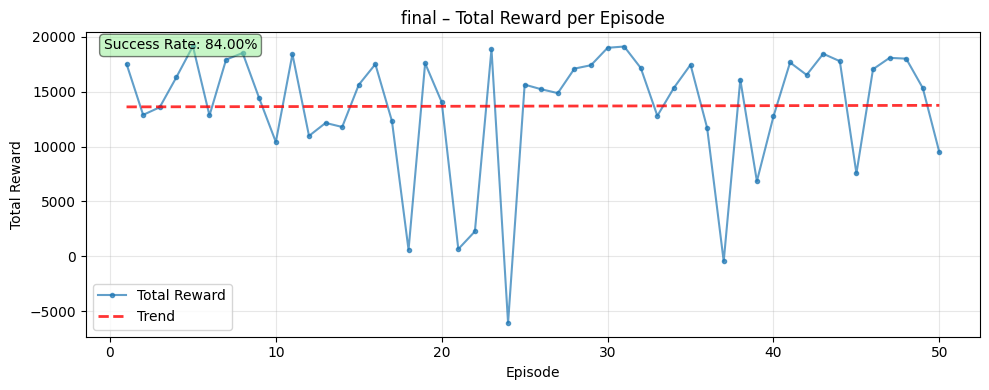

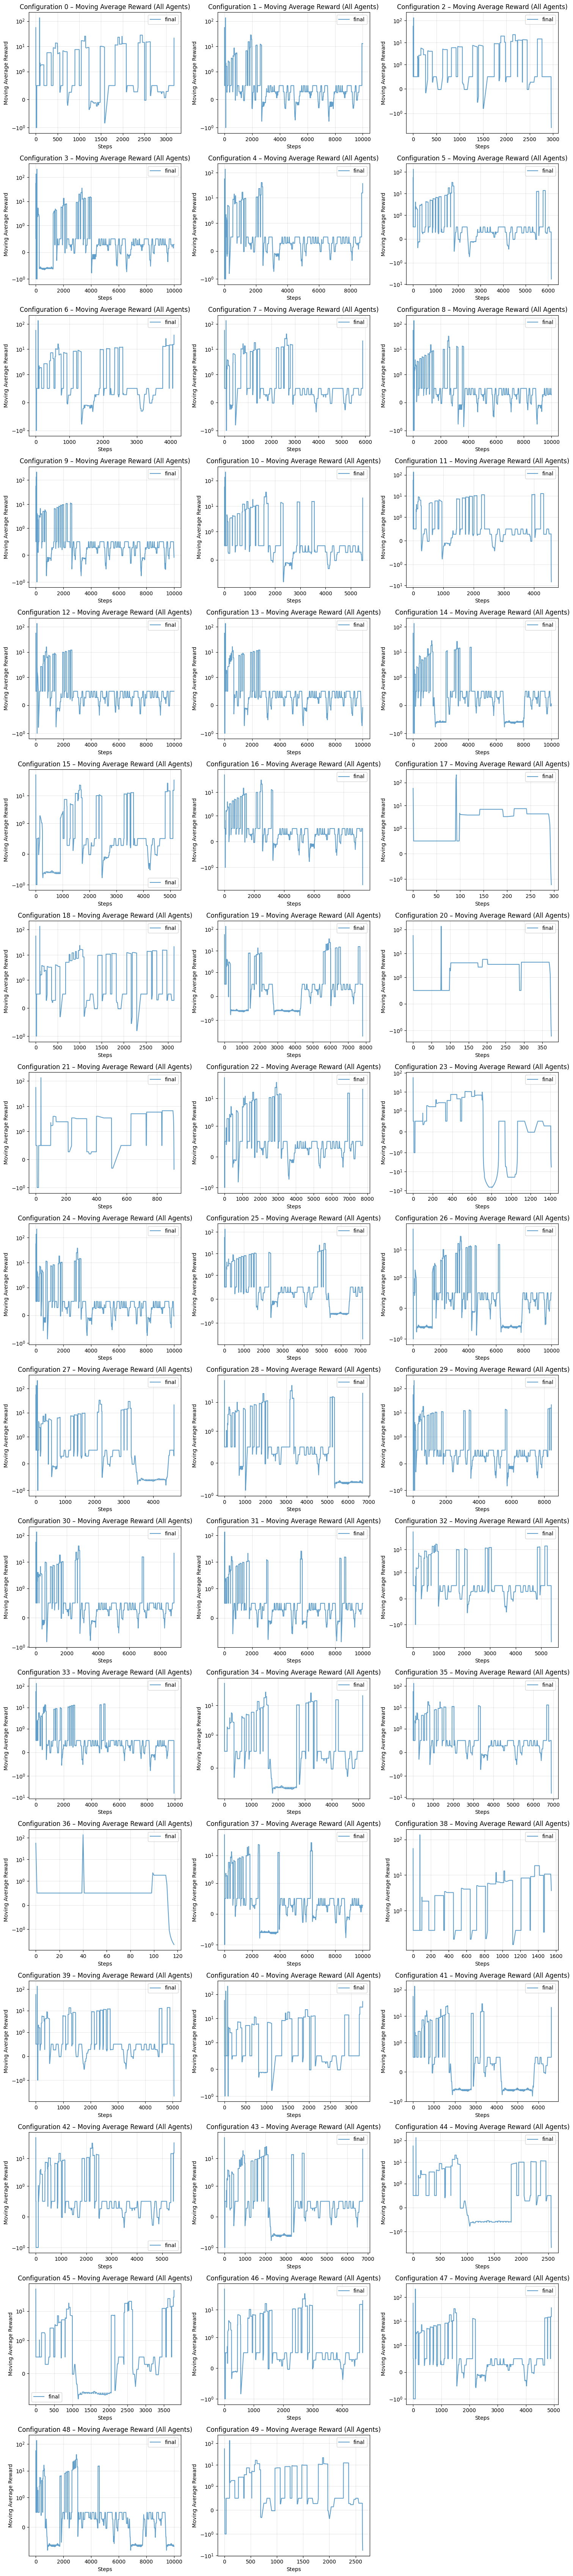

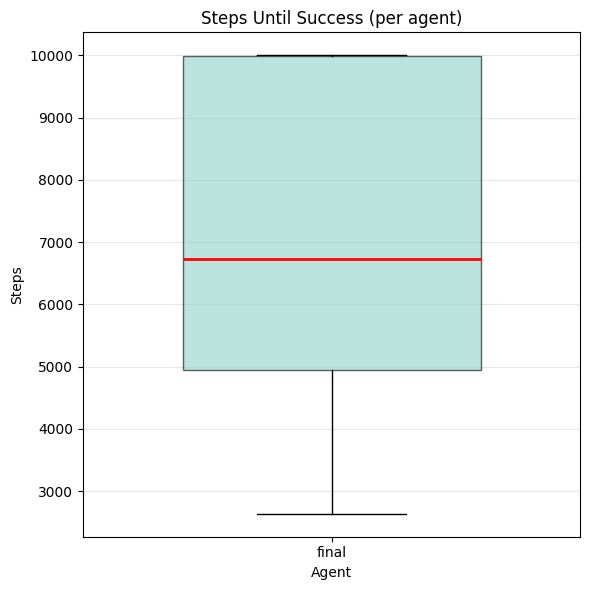

In [18]:
plot_all_q_agent(final_results_5, agents=["final"])

Aumentando il valore di soglia al **70%** si osserva un leggero calo delle performance dell’agente, che tuttavia mantiene una buona capacità di esplorazione anche con requisiti più stringenti.

In [19]:
did_succeed = lambda reward, termination, truncation, info: info.get("explored_ratio", 0) >= 0.70

In [20]:
final_results_5 = evaluate(env=q_env5, agents=q_agents, configs=configs_5, max_steps=10000, did_succeed=did_succeed)

Evaluation: 100%|██████████| 50/50 [23:16<00:00, 27.94s/configuration run]


In [21]:
final_results_5 = rename_inner_keys(final_results_5, {agent_id: "final"})

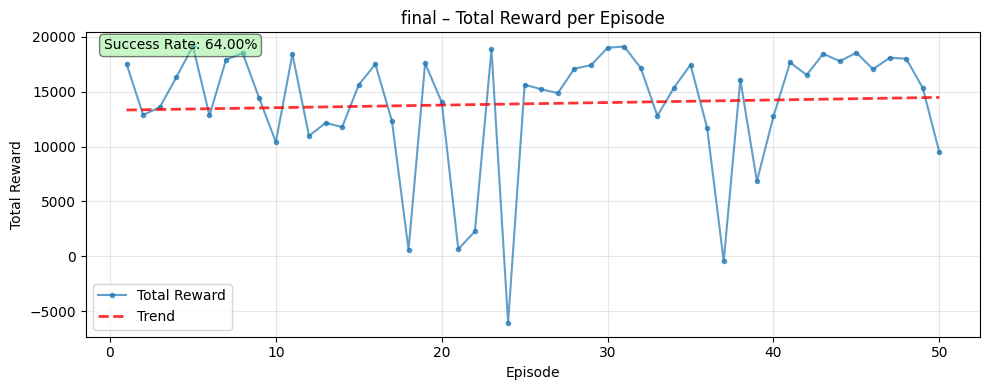

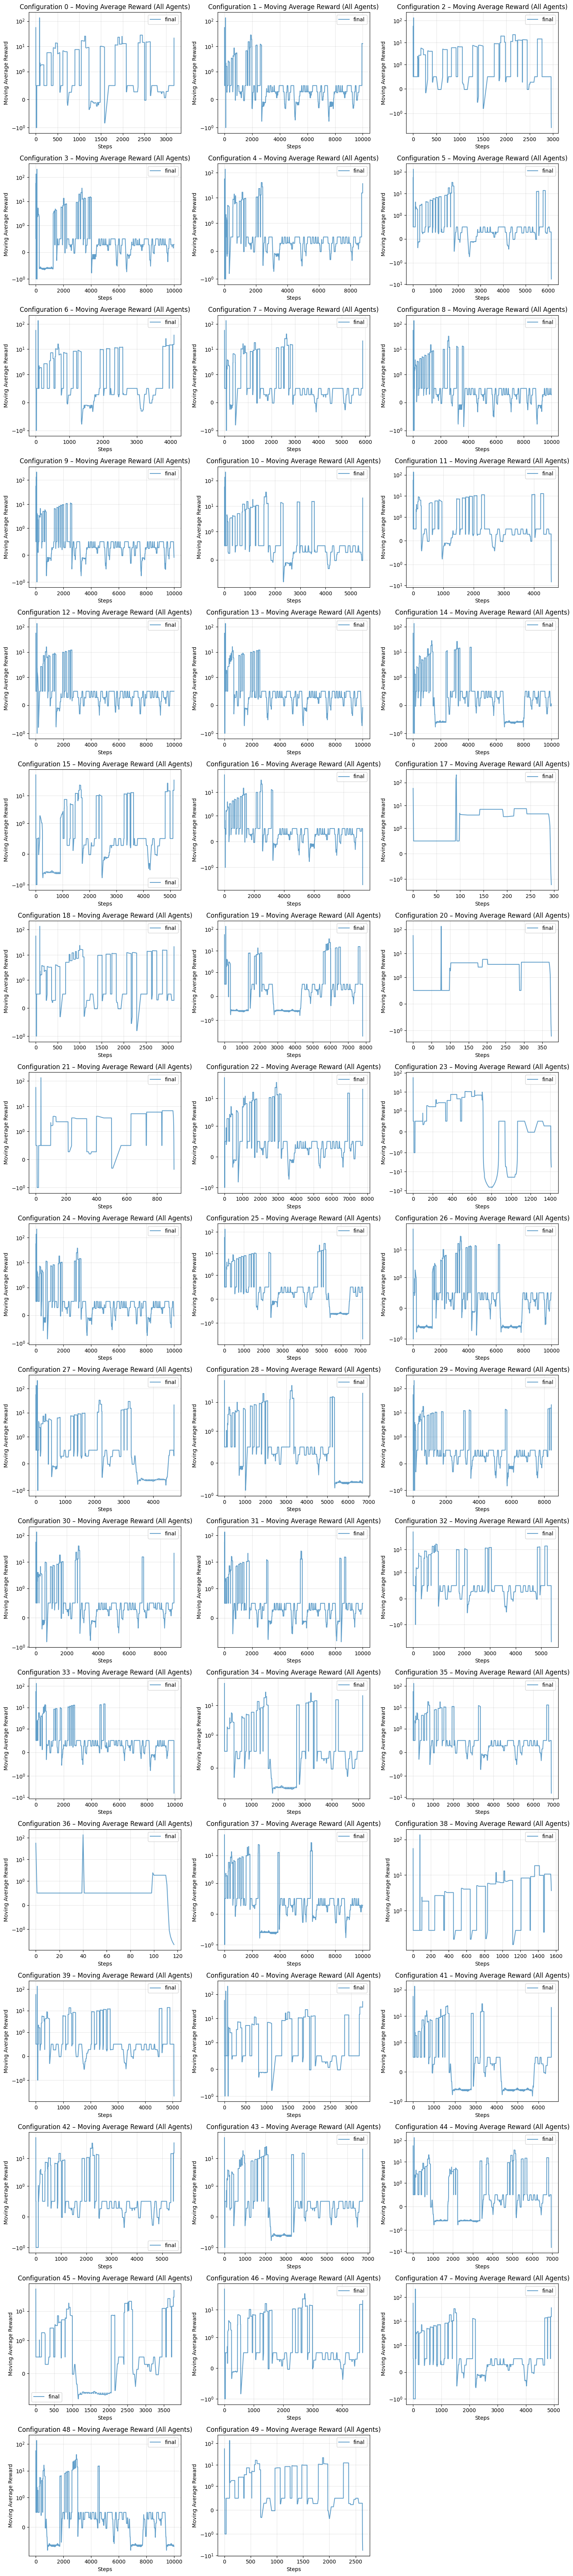

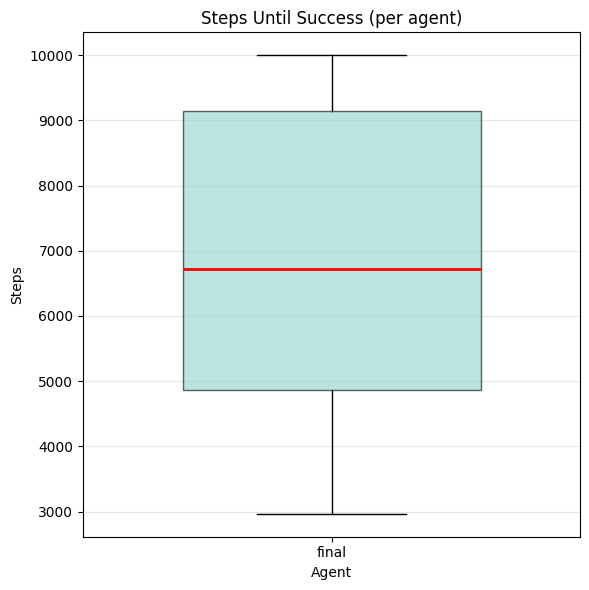

In [22]:
plot_all_q_agent(final_results_5, agents=["final"])

Aumentando ulteriormente la soglia al **80%**, si nota un calo più significativo delle performance, indicando che l’agente fatica a raggiungere livelli di copertura molto elevati.

In [23]:
did_succeed = lambda reward, termination, truncation, info: info.get("explored_ratio", 0) >= 0.80

Evaluation: 100%|██████████| 50/50 [17:56<00:00, 21.53s/configuration run]


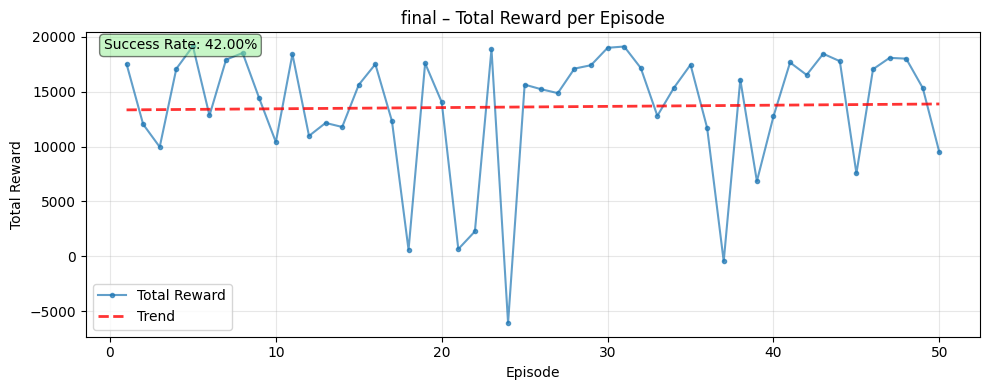

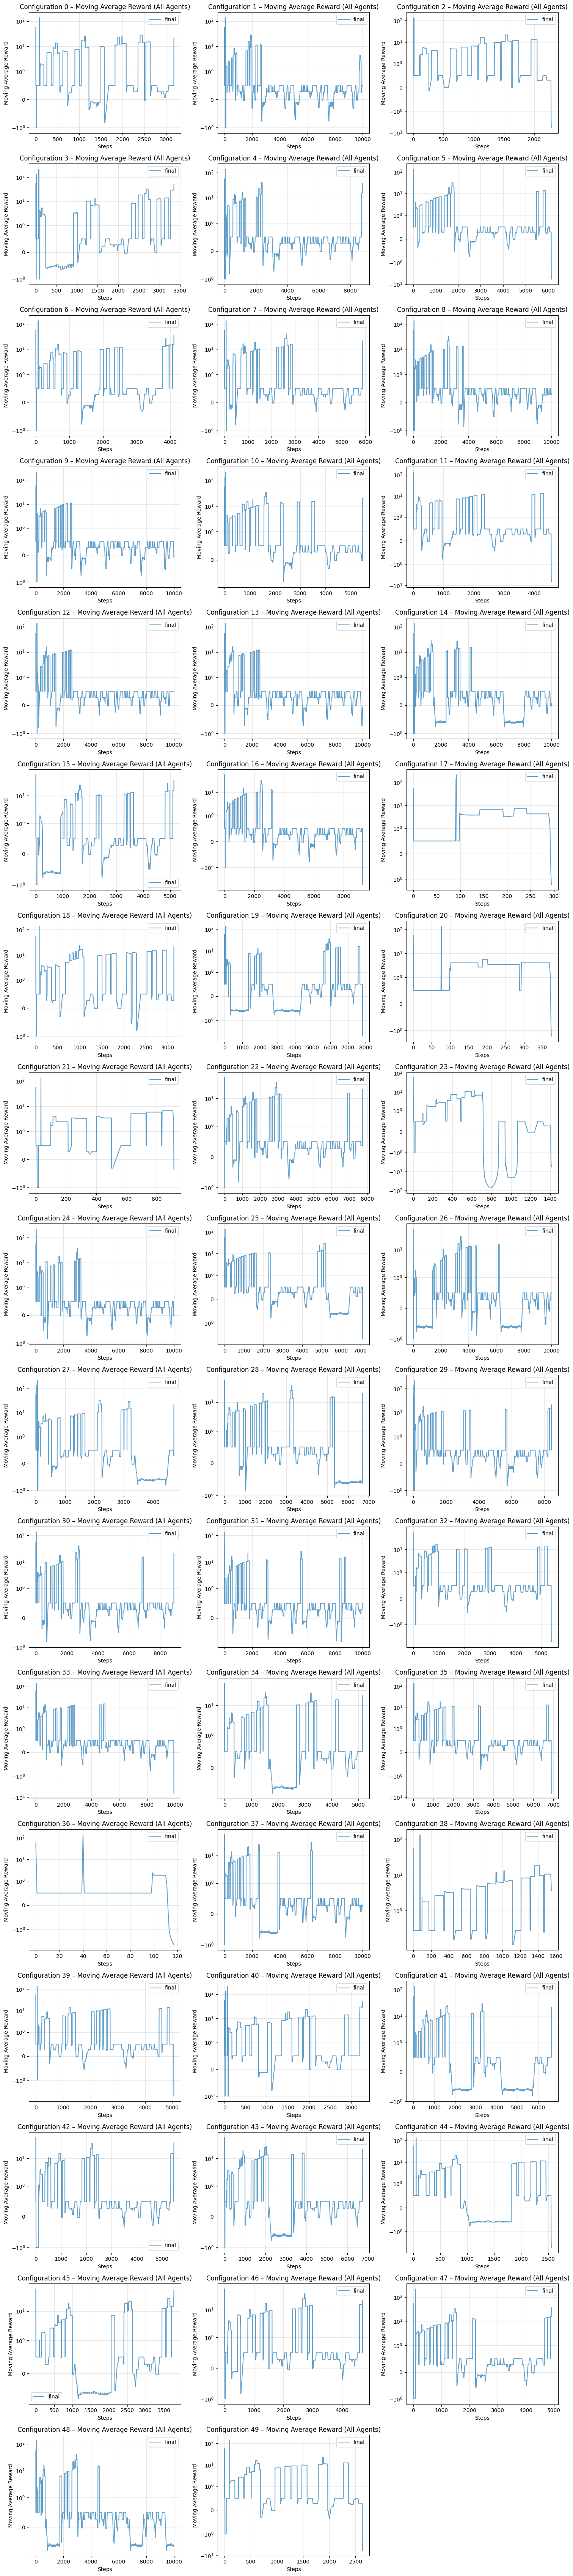

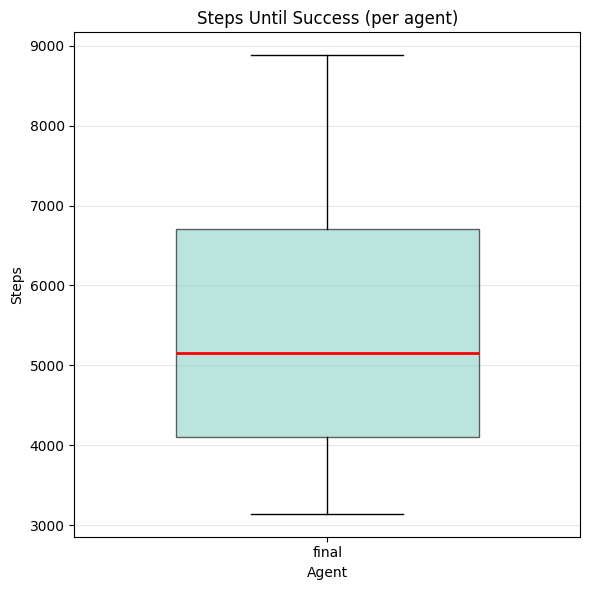

In [24]:
final_results_5 = evaluate(env=q_env5, agents=q_agents, configs=configs_5, max_steps=10000, did_succeed=did_succeed)
final_results_5 = rename_inner_keys(final_results_5, {agent_id: "final"})
plot_all_q_agent(final_results_5, agents=["final"])

Esempio di episodio di test con copertura del 80% in ambiente 5x5:

![DQ-Agent OK](../resources/exploration-qagent-ok.gif)

Per l'ambiente 5x5, l'agente basato su Q-learning tabellare mostra buone capacità di esplorazione, riuscendo a coprire una porzione significativa della mappa in molti episodi di test. Tuttavia, le performance tendono a diminuire con l'aumentare della soglia di successo richiesta, evidenziando alcune limitazioni nell'approccio tabellare, soprattutto in termini di generalizzazione e gestione di situazioni complesse.

Tabella riassuntiva dei risultati:
| Soglia di Successo | Tasso di Successo | Passi Medi |
|--------------------|-------------------|------------|
| 60%                | 84%               | 6000-7000  |
| 70%                | 64%               | 6000-7000  |
| 80%                | 42%               | 5000-6000  |

### Replicazione dei passaggi per l’ambiente 10×10

L'agente Q-learning tabellare è stato addestrato anche in un ambiente di dimensioni 10×10 metri sempre con 5000 episodi, seguendo la stessa metodologia utilizzata per l'ambiente 5×5. Di seguito sono riportati i passaggi principali per la connessione all'ambiente, il caricamento dell'agente salvato e la valutazione delle sue performance.

In [60]:
server_address = "localhost:50051"
client_name = "RLClient"
q_env10 = ExplorationEnv(server_address, client_name, grid_size=(10, 10), orientation_bins=8)
q_env10.connect_to_client()

q_agent10 = QAgent(q_env10)
agent_id = "00000000-0000-0000-0000-000000000001"
q_agents = {agent_id: q_agent10}
path = get_yaml_path("src", "scripts", "resources", "generated", "new", "exploration", "10x10", "checkpoints_final")
q_agent10.load(path)

print("Agent hyperparameters:")
print(f"\tEpsilon-max: {q_agent10.epsilon_max}")
print(f"\tEpsilon-min: {q_agent10.epsilon_min}")
print(f"\tAlpha: {q_agent10.alpha}")
print(f"\tGamma: {q_agent10.gamma}")

# 10x10 configurations
config_10_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "q-learning", "exploration", "10x10new")
yml_files_10 = sorted(config_10_path.glob("*.yml"), key=lambda p: p.name)
configs_10 = [read_file(yml) for yml in yml_files_10]

2025-12-11 17:05:42,979 — INFO — Discrete(5)
2025-12-11 17:05:42,982 — INFO — Discrete(800)
2025-12-11 17:05:42,984 — INFO — 100
2025-12-11 17:05:42,989 — INFO — ✓ Connected to localhost:50051

2025-12-11 17:05:44,377 — INFO — Agent loaded from C:\Users\HP\Desktop\UNIBO\LaureaMagistrale\1_anno\Paradigmi di Programmazione e Sviluppo (PPS)\Esame\PPS-22-srs\python\src\scripts\resources\generated\new\exploration\10x10\checkpoints_final.npz
2025-12-11 17:05:44,378 — INFO —   Q-table shape: (800, 5)
2025-12-11 17:05:44,379 — INFO —   Current epsilon: 0.0020
2025-12-11 17:05:44,380 — INFO —   Total episodes trained: 5000
Agent hyperparameters:
	Epsilon-max: 1.0
	Epsilon-min: 0.001
	Alpha: 0.5
	Gamma: 0.99


Si procede con la valutazione dell’agente nell’ambiente 10×10, iniziando con una soglia di successo del **50%** e **60%** di copertura della mappa.

Evaluation: 100%|██████████| 14/14 [33:41<00:00, 144.41s/configuration run]


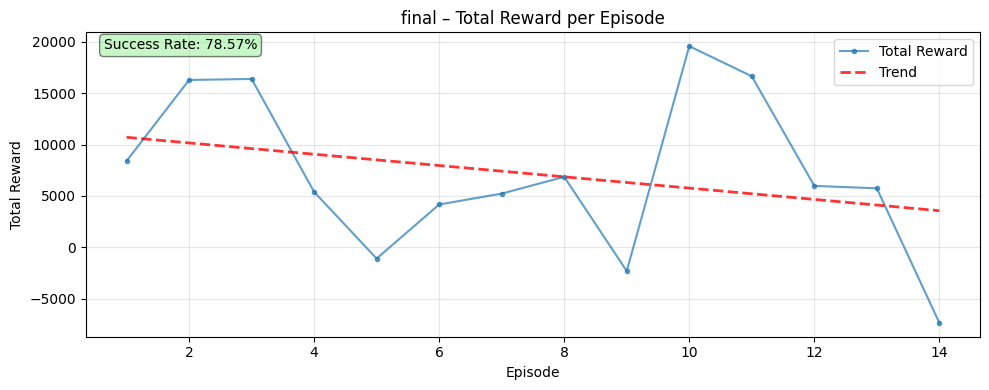

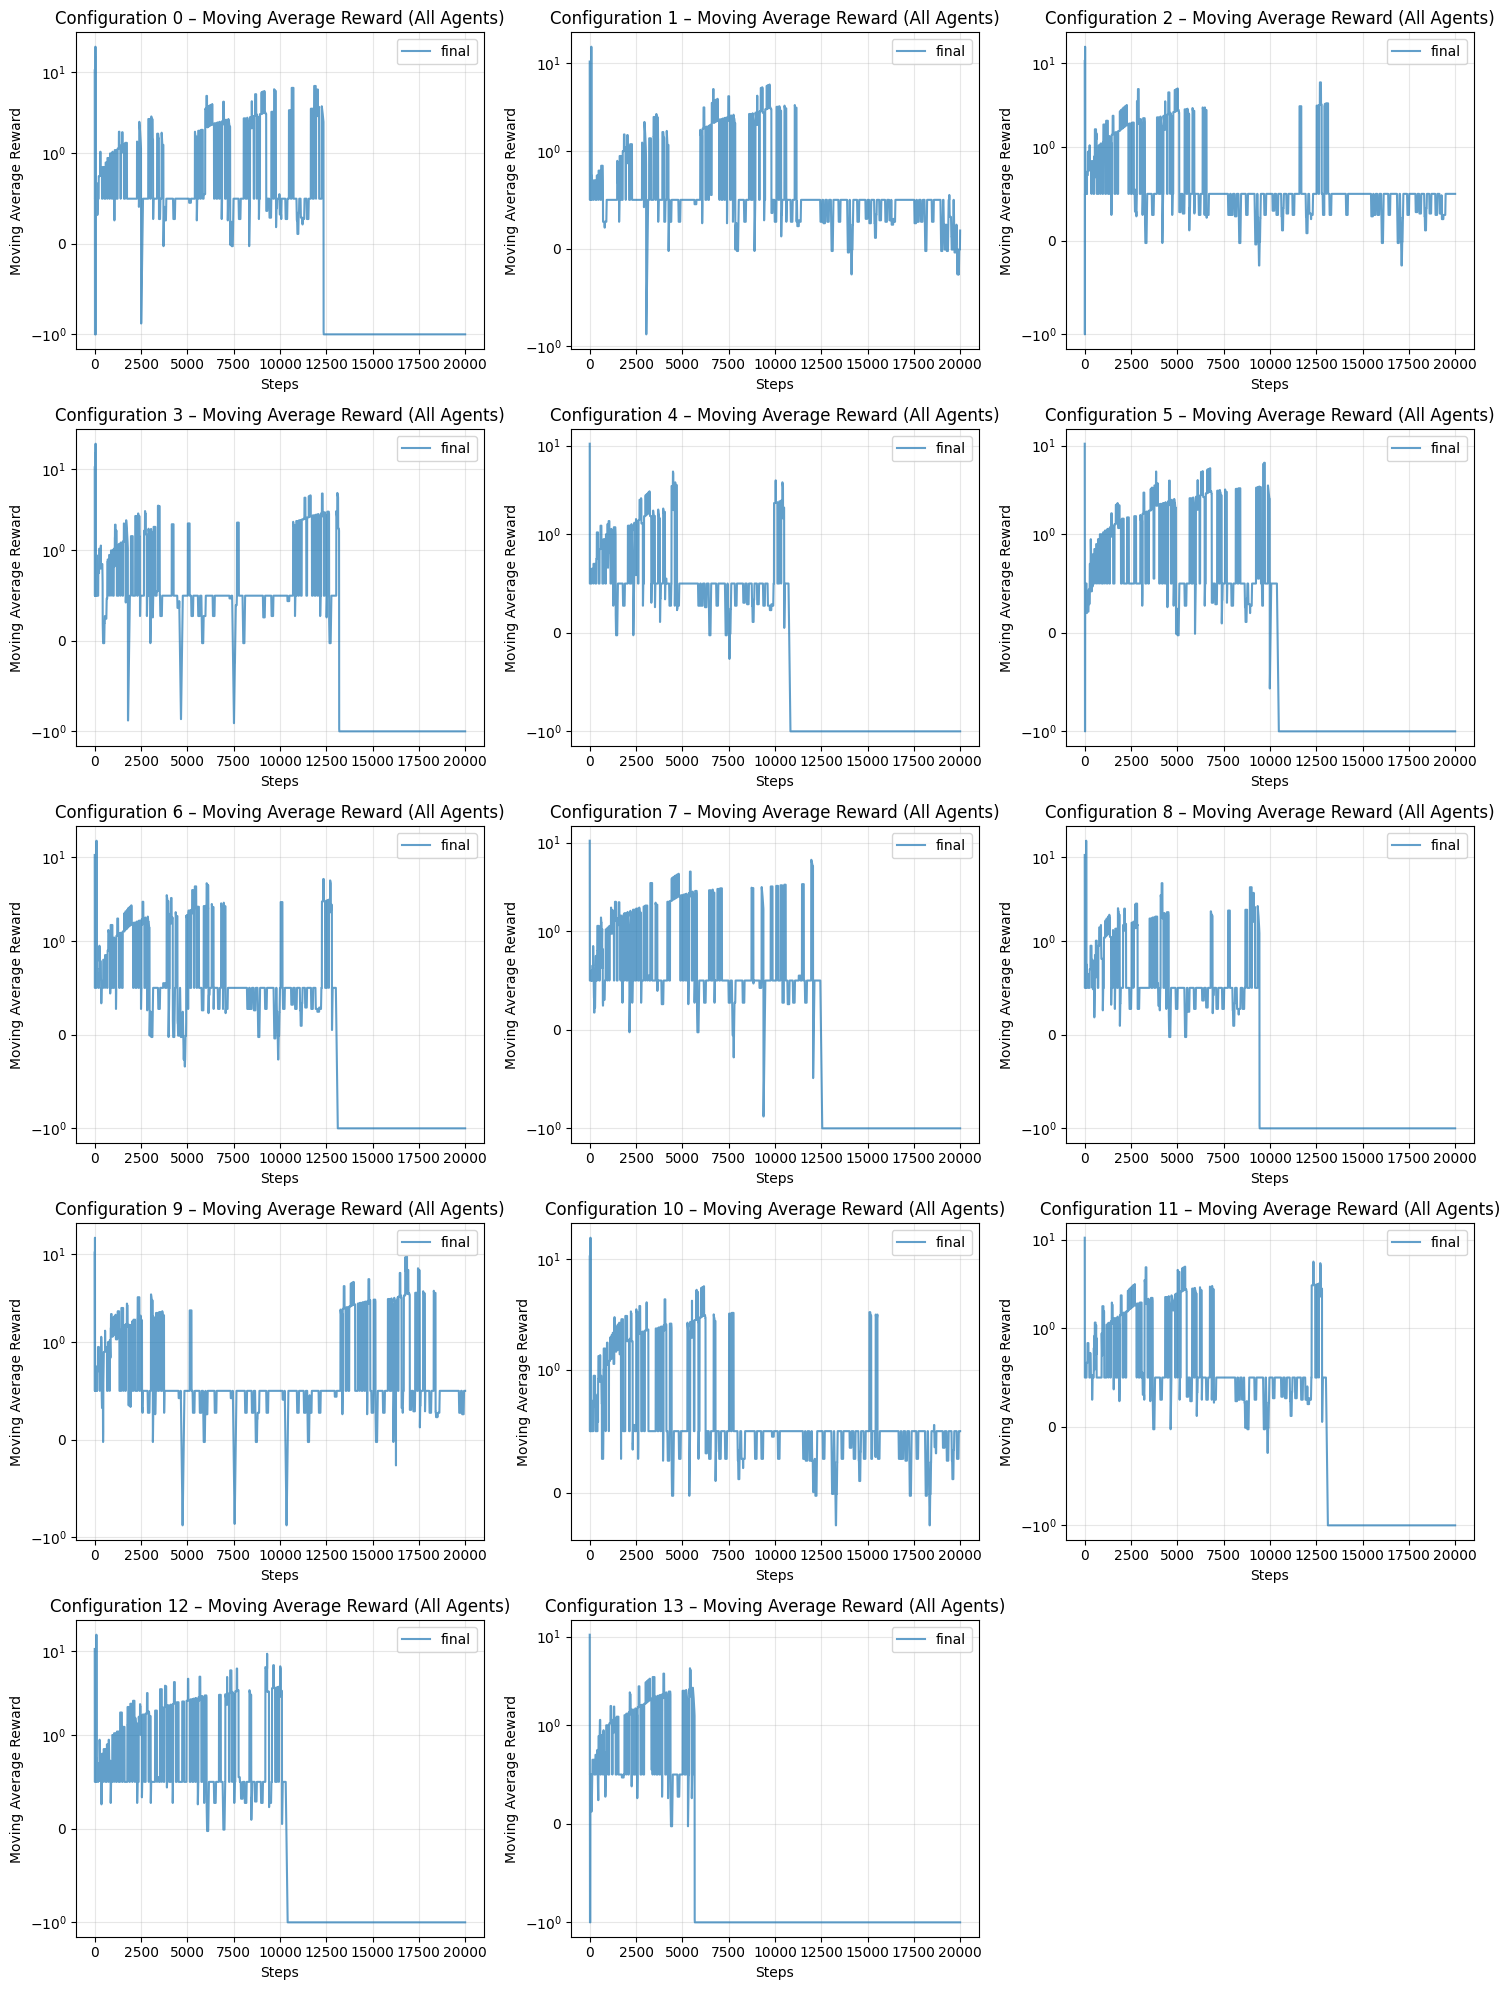

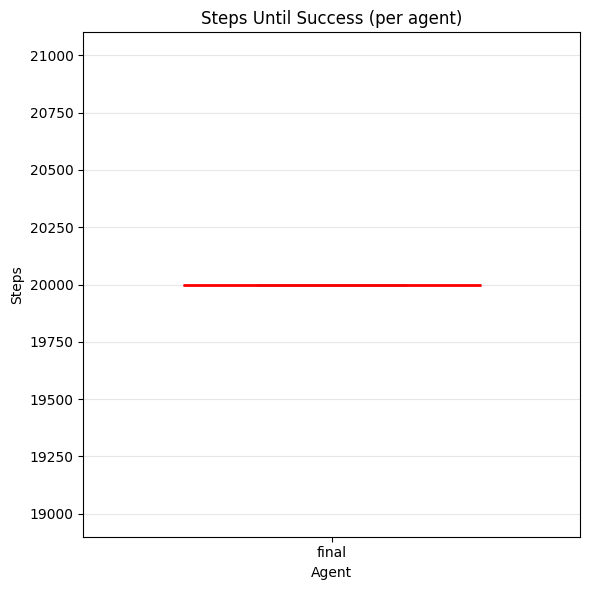

In [62]:
did_succeed = lambda reward, termination, truncation, info: info.get("explored_ratio", 0) >= 0.50

final_results_10 = evaluate(env=q_env10, agents=q_agents, configs=configs_10, max_steps=20000, did_succeed=did_succeed)
final_results_10 = rename_inner_keys(final_results_10, {agent_id: "final"})
plot_all_q_agent(final_results_10, agents=["final"])

Evaluation: 100%|██████████| 14/14 [30:39<00:00, 131.39s/configuration run]


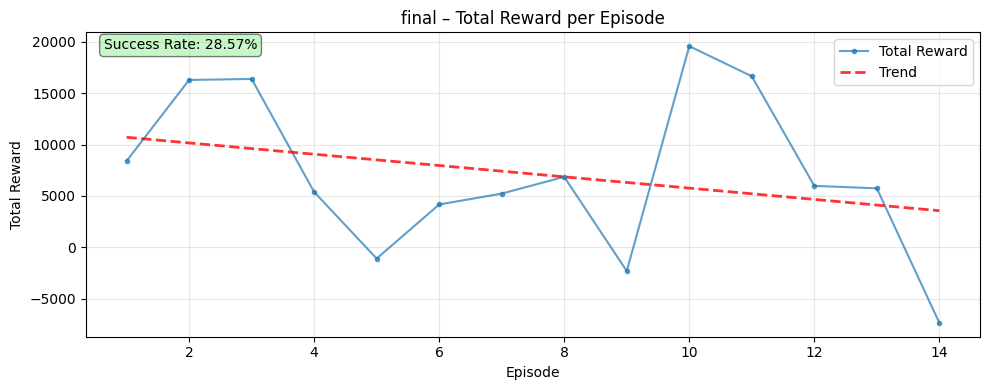

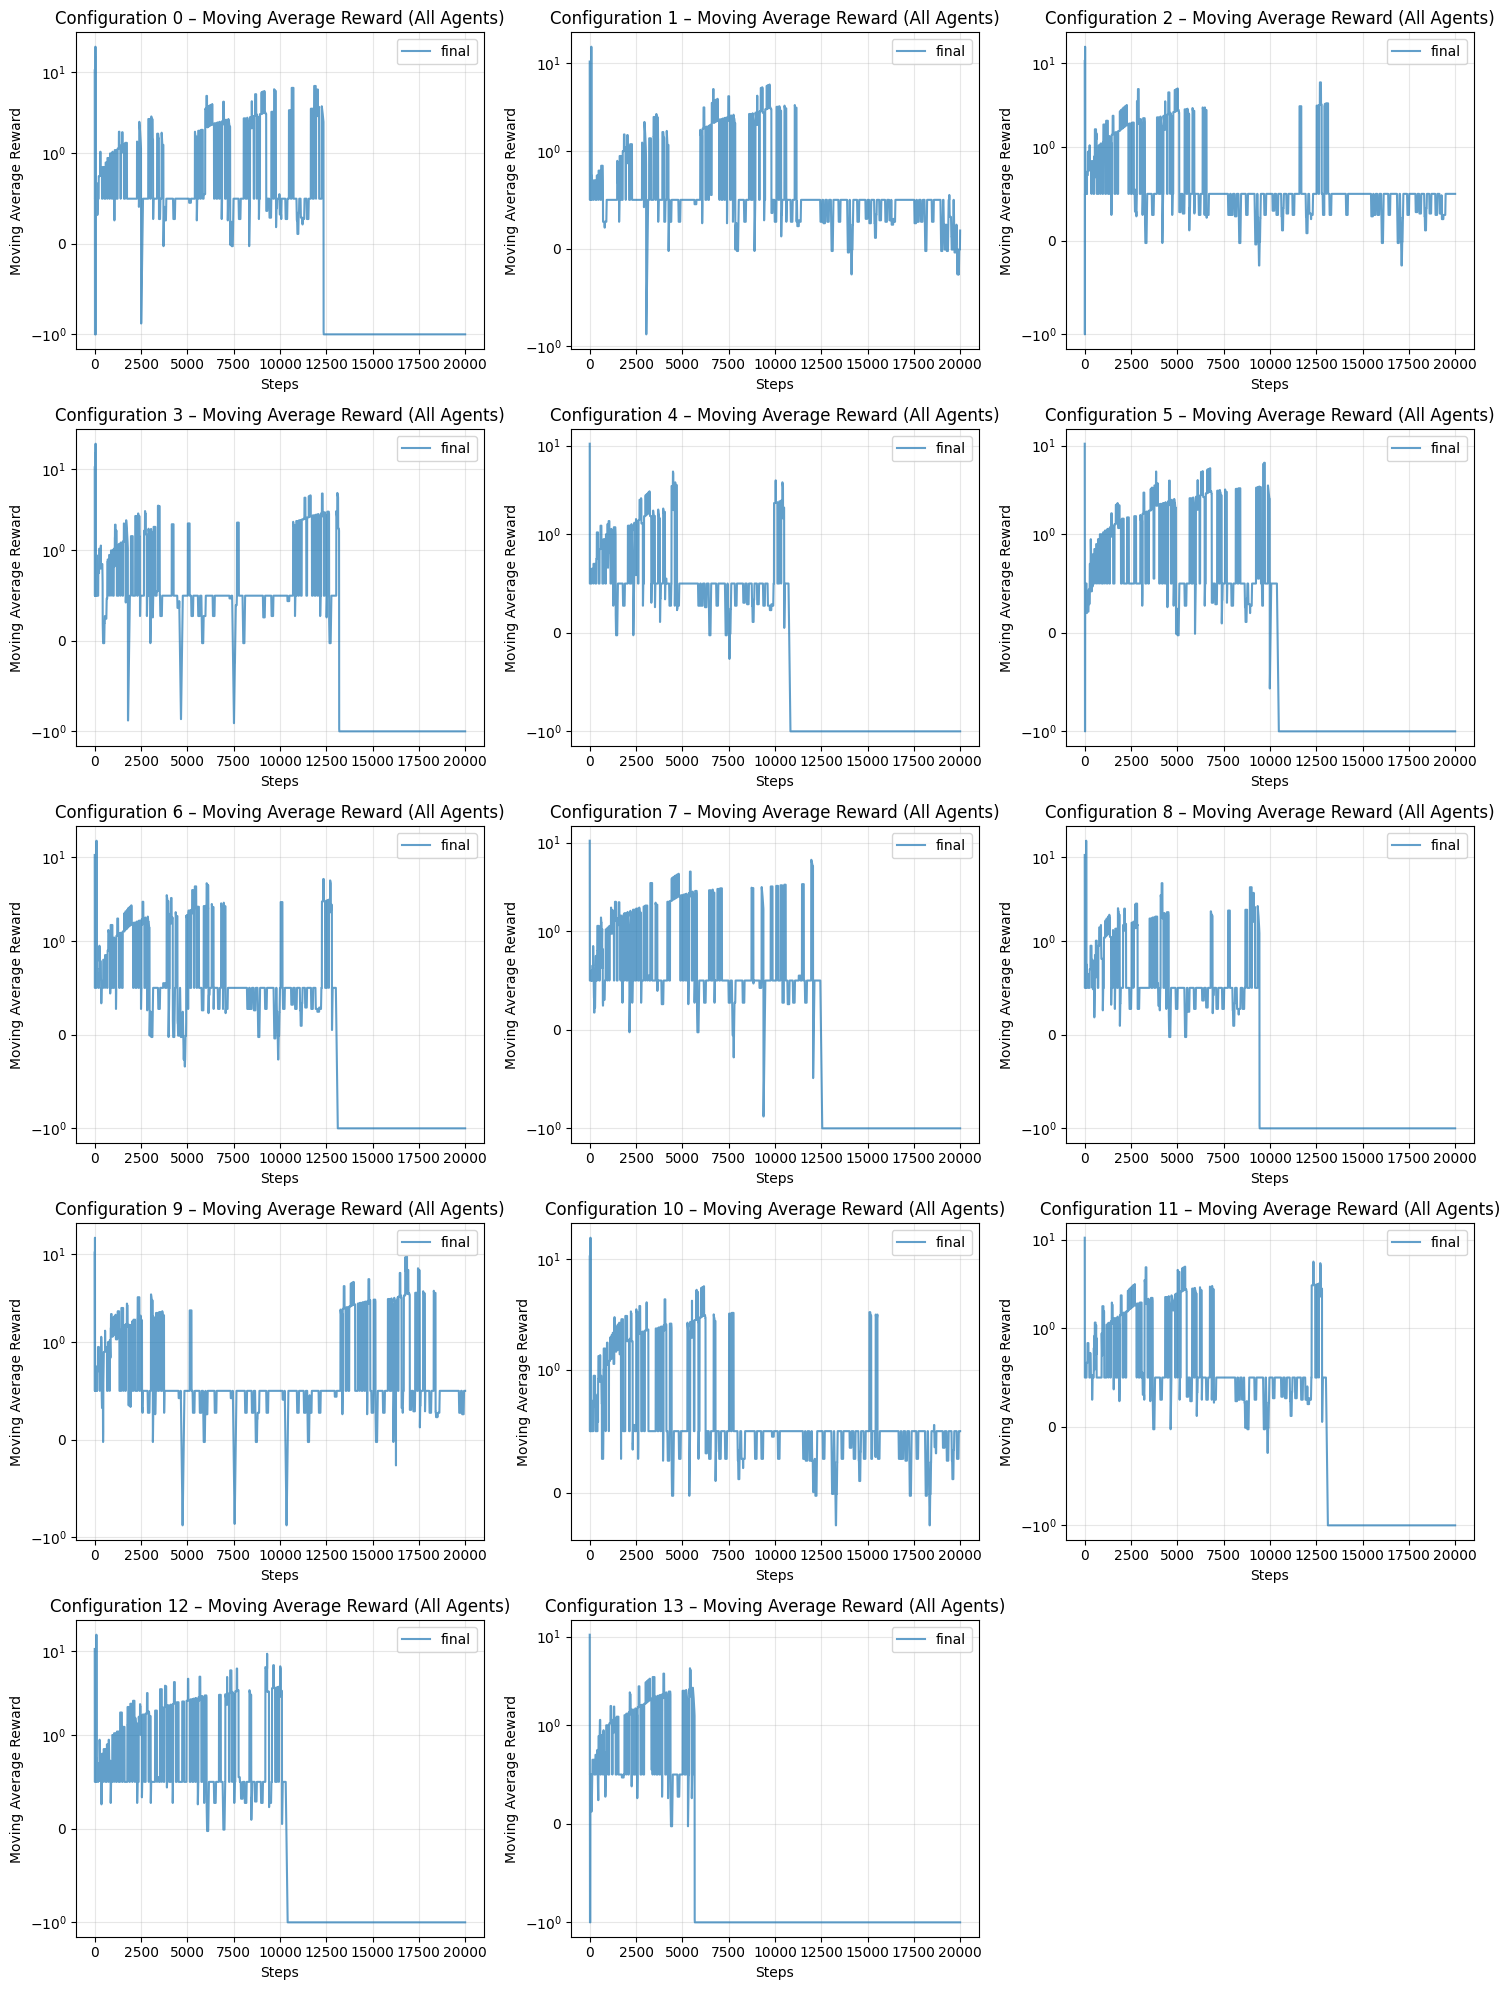

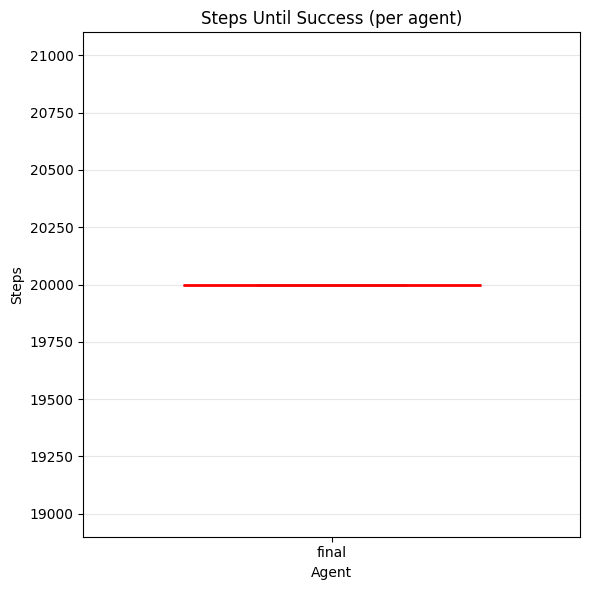

In [61]:
did_succeed = lambda reward, termination, truncation, info: info.get("explored_ratio", 0) >= 0.60

final_results_10 = evaluate(env=q_env10, agents=q_agents, configs=configs_10, max_steps=20000, did_succeed=did_succeed)
final_results_10 = rename_inner_keys(final_results_10, {agent_id: "final"})
plot_all_q_agent(final_results_10, agents=["final"])

Le prove con l’agente Q-learning tabellare in ambiente 10×10 mostrano una riduzione delle performance rispetto all’ambiente 5×5, evidenziando le difficoltà dell’approccio tabellare nel gestire spazi di stato più ampi. In particolare, il tasso di successo diminuisce significativamente con l’aumentare della soglia di copertura richiesta, indicando che l’agente fatica a esplorare efficacemente l’intera area.

Tabella riassuntiva dei risultati:
| Soglia di Successo | Tasso di Successo |
|--------------------|-------------------|
| 50%                | 78,57%            |
| 60%                | 28,57%            |

I passi medi si attestano a 20000, il che significa che l'agente spesso utilizza il numero massimo di passi disponibili senza riuscire a completare l’esplorazione richiesta.

### Analisi errori

Di seguito sono riportate le principali criticità riscontrate utilizzando l’approccio basato su Q-Learning tabellare nel task di exploration.

#### Polarizzazione sugli stati visitati più spesso

Una delle limitazioni più evidenti riguarda la scarsa capacità di generalizzazione dell’agente.
Nel Q-learning tabellare, infatti, ogni stato viene appreso esclusivamente quando viene visitato: non esiste la possibilità di inferire valori per stati simili o per regioni spaziali non ancora esplorate.

Questo comporta una forte polarizzazione verso gli stati più frequenti, con i seguenti effetti:
- esplorazione incompleta della mappa;
- tendenza a permanere in regioni note;
- difficoltà nel recuperare situazioni iniziali sfavorevoli.

Il problema è amplificato dalla codifica dello stato basata sulle coordinate (x, y) e dall’ampiezza dello spazio degli stati.

Esempio di episodio di test con copertura del 60% in ambiente 5x5, dove l'agente rimane nelle stesse celle già visitate, l'episodio termina per raggiungimento del numero massimo di passi:
![Q-Agent Same Visited Cells](../resources/exploration-qagent-same-visited-cells.gif)

#### Difficoltà nell’uscire da loop comportamentali

I loop comportamentali si verificano quando l’agente entra in una sequenza ricorrente di stati e azioni che non producono alcun avanzamento significativo nell’esplorazione della mappa.
Nonostante la penalità per lo stallo, l’agente può comunque rimanere intrappolato in:
- piccoli cicli di azioni ripetute;
- rotazioni continue sul posto quando la reward locale non fornisce indicazioni chiare.

Nel contesto del task di exploration, tali loop si manifestano più frequentemente:
- nelle vicinanze di pareti o angoli;
- in zone già ampiamente esplorate e quindi con reward marginali o nulle;
- quando la struttura della reward locale non fornisce all’agente un’indicazione chiara su quale direzione favorisca una maggiore copertura.

Il Q-learning tabellare, per sua natura, non possiede memoria a lungo termine né un modello dell’ambiente, e non può riconoscere esplicitamente di trovarsi in un ciclo ricorrente.
Di conseguenza, quando i valori di Q associati alle azioni disponibili in uno stato sono simili o poco informativi, l’agente tende a reiterare la prima sequenza che gli restituisce una reward non particolarmente negativa, restando intrappolato nel loop.

Quando ciò accade, la *Mean Average Reward* tende a stabilizzarsi su valori negativi, poiché le penalità accumulate durante le azioni ripetitive superano eventuali reward locali.

Questi fenomeni rappresentano uno dei limiti più noti dei metodi tabellari: una volta instaurati, i loop comportamentali sono difficili da eliminare, e le performance dell’agente diventano meno prevedibili e meno robuste.

Esempio di episodio di test in ambiente 10x10, in cui l'agente entra in un loop comportamentale:
![Q-Agent Loop Behavior](../resources/exploration-qagent-loop.gif)

#### Sensibilità elevata al design della reward

Sono state testate molteplici versioni della funzione di reward.
Si è osservato che:
- reward troppo complesse tendevano a introdurre rumore, causando instabilità;
- reward troppo ricche di bonus/penalità portavano l’agente a ottimizzare un solo aspetto del comportamento;
- reward più semplici risultavano più stabili ma non sempre sufficienti a guidare l’esplorazione completa.

Nel task di exploration, questo problema è particolarmente rilevante poiché la reward è intrinsecamente **sparsa**: solo la scoperta di nuove celle fornisce un segnale utile.
L'agente, in assenza di un modello dell’ambiente, dipende quindi in modo critico dalla qualità del segnale di reward fornito.

Anche la versione attuale, pur essendo la più efficace tra quelle testate, non garantisce prestazioni ottimali in tutte le configurazioni e presenta margini di miglioramento.

### Commenti finali

# DQ-Learning

Il task di exploration è stato successivamente affrontato utilizzando un agente basato su Deep Q-Learning (DQN).

Il passaggio da un approccio tabellare a uno neurale si è reso necessario per superare alcune delle limitazioni osservate con il Q-learning classico.

Per garantire un confronto diretto tra i due approcci, l’implementazione iniziale del DQ-Agent ha riutilizzato la stessa struttura logica del Q-Agent, mantenendo:
- la medesima funzione di reward utilizzata nel Q-Learning tabellare;
- il medesimo set di azioni disponibili;
- le stesse configurazioni ambientali per addestramento e valutazione.

Questa configurazione di partenza ha permesso di isolare gli effetti dell’approssimazione tramite rete neurale, prima di introdurre modifiche più sostanziali.

Successivamente, l’architettura DQN è stata estesa per sfruttare appieno le sue capacità:
sono state integrate le letture dei sensori di prossimità direttamente come input della rete neurale, cosa impossibile nel Q-Learning tabellare a causa dell’elevata dimensionalità dello stato.

In una fase successiva, la funzione di reward è stata modificata e resa più densa, passando da una reward “sparsa”, tipica del task di exploration, a una formulazione più informativa, in grado di guidare in modo più efficace l’apprendimento dell’agente nelle prime fasi dell’esplorazione.
Questa riformulazione è stata resa possibile proprio grazie alla flessibilità introdotta dal modello neurale, che può apprendere da segnali più ricchi senza dover enumerare esplicitamente ogni stato possibile.

## Import delle librerie

## Connessione all'ambiente

### Problemi riscontrati

### Configurazione ambienti

## Approccio risolutivo

Di seguito vengono mostrate le soluzioni adottate per risolvere i problemi riscontrati e la realizzazione dell'agente di Deep Q-Learning.

### Reward

Come descritto nei problemi riscontrati, la funzione di reward utilizzata per addestrare il Q-Agent non si è rivelata adatta per il DQ-Agent.

### Termination

Per la terminazione dell'episodio si è mantenuta la stessa regola utilizzata per il Q-Agent, ovvero la terminazione avviene in caso di collisione con un ostacolo/bordo (terminazione negativa) oppure in caso di raggiungimento di un certo valore di soglia, fissato all'**80%** della copertura della mappa (terminazione positiva).

### Truncation

Anche per la troncatura dell'episodio si è mantenuta la stessa regola utilizzata per il Q-Agent, ovvero l'episodio viene troncato quando l'agente raggiunge il numero massimo di passi consentiti per l'ambiente in cui si trova.